## Background on Magic: the Gathering

For those unfamiliar, Magic is a collectible card game (its digital implementation is called Magic: the Gathering Arena, or MTGA). There are a lot of rules (252 pages) that aren't relevant and I won't get into. What's important to know is that at the start of a game, you draw a hand of 7 from a deck that you've constructed (you also draw a card every turn after that). In this hand, you'll probably have some combination of lands and spells. (In the image below, there are two lands ('Forest') and 5 spells. 

Lands are important because they provide "mana". Each spell has an associated "mana cost", found in the top right of the card, that you are required to pay in order to play the card. You can see that Owbear has an overall cost of 5. So, to play Owlbear, you would need 5 lands. 

Drawing either too few or too many lands in your starting hand will naturally cause problems. Drawing too few lands leaves you unable to pay the mana cost of your spells, while drawing too many lands leaves you with no spells to play. For this reason, certain hand distributions may be more preferred than others. Using a bot, I joined 1046 MTGA matches (with another bot, so as to not waste the time of real players) and extracted data from the log files to find land distributions. 

<img src="mtga_hand.jpg" width=900 height=900 />

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd

In [2]:
mulligan_log = open("bot.txt", "r")
mulligan_string = mulligan_log.read()
lines = mulligan_log.readlines()

In the game logs, everything in the same hand is stored on the same line. So, I'll read everything in line-by-line, and then do a regex search on each line for what I want. 

In [3]:
lines = []
with open("bot.txt") as f:
    for line in f:
        lines.append(line)

In [4]:
matches = []
for l in lines:
    line = re.findall("(gameObjects)(.*?)(}\n)", l)
    if line != []:
        matches.append(line)

num_hands = len(matches) #Data for each hand is contained within a single line. 

In [5]:
count_lands = []
for i in range(num_hands):
    count_lands.append(str(matches[i]).count("SubType_Forest"))

In [6]:
d = {x:count_lands.count(x) for x in count_lands}
a, b = d.keys(), d.values()
land_counts = [0, 3, 312, 620, 111, 0, 0, 0]
frequency = [0, 3/num_hands, 312/num_hands, 620/num_hands, 111/num_hands, 0, 0, 0]

We expect a [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution) (were it not to be smoothed) where K is the total number of lands, N is the size of your deck, k is the number of lands chosen, and n is the hand size. 

In [7]:
N = 60
K = 24
n = 7
p_x = [math.comb(24, k) * math.comb(N - K, n - k)/math.comb(N, n) for k in range(0, 8)]

Text(0, 0.5, 'Frequency')

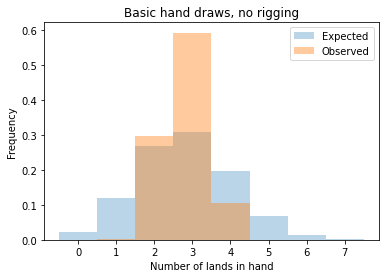

In [30]:
fig, ax = plt.subplots()
ax.bar(np.arange(0,8), p_x, 1, zorder = 1, alpha = .3, label = 'Expected')
ax.bar(np.arange(0,8), frequency, 1,  zorder = 2, alpha = .4, label = 'Observed')
ax.legend(loc="upper right")
ax.set_title("Basic hand draws, no rigging")
ax.set_xlabel("Number of lands in hand")
ax.set_ylabel("Frequency")

What is the process that MTGA uses to smooth? Here's what was said in 2018 by Ryan Spain, one of the MTGA designers: https://forums.mtgarena.com/forums/threads/347

"MTG Arena has a system for randomizing opening hands in single-game matches that is different from the traditional method. We knew early on that the ability to play a meaningful single game of Magic would be an important part of the MTG Arena play options for the time-constrained player, but in testing, losing a single-game match after a mulligan felt worse than normal without the fallback plan of winning the other two games.

To mitigate this loss of the “foul to give” built into best-of-three matches, we wanted to randomize starting hands in a way that would reduce the frequency of mulligans, but without incentivizing mana-base construction outside the strategic norms of the game. Here’s how it works:

<b>The system draws an opening hand from each of two separately randomized copies of the decks, and leans towards giving the player the hand with the mix of spells and lands (without regard for color) closest to average for that deck<b>.
You can then use standard Vancouver Mulligan rules to get a new hand with one fewer card. Mulliganed hands are created from a single randomized draw.

We feel this achieves the desired effect of reducing the frequency of mulligans without changing how players build their mana bases, but we will be looking at data and listening to feedback on this system, so let us know what you think. Remember that this won’t make all your starting hands perfect! You will probably have some stretches of hands where you think we must have turned this system off. The overall mulligan rate should be lower, though, and we hope that will create a better-feeling but strategically authentic experience for single-game matches."


### Simulating Supposed Smoothing Strategy 

I'll simulate the strategy outlined by Ryan Spain. Does it looks like MTGA still uses the strategy he described? It's also plausible that different algorithms are used for different formats. I have only tested this with bot matches so far, and I assume the vast majority of people playing bot matches are complete beginners (you don't get XP and you can't make quest progress with bot matches). A beginner is more likely to be offput than a seasoned player by bad RNG, enough so that it could plausibly contribute to them quitting the game. 

In the future, I'll have to test this in the "Standard Play" and "Standard Ranked" formats, which I have thus far avoided because I didn't want to annoy real players. Best-of-3 games will also be interesting to try out and (in my opinion) has the highest likelihood of using less smoothing because repeated matches are already a good defense against RNG, but I'll likely need to make the bot work based off of screen detection if I do this because the queue times are fairly inconsistent. 

In [9]:
comb_probs = [[p_x[i]*p_x[j] for i in range(len(p_x))] for j in range(len(p_x))]

In [10]:
prob_combinations = pd.DataFrame(comb_probs,
                   columns=np.arange(0,8))

The table below outlines the probability of drawing pair of hands with any combination of lands (for example, there is a 9.5 percent chance that both hands have 3 lands). 

In [11]:
prob_combinations.style

,0,1,2,3,4,5,6,7
0,0.000467,0.002616,0.005823,0.006672,0.004246,0.001499,0.000271,0.000019
1,0.002616,0.014651,0.032610,0.037366,0.023778,0.008392,0.001519,0.000108
2,0.005823,0.032610,0.072584,0.083169,0.052926,0.018680,0.003380,0.000241
3,0.006672,0.037366,0.083169,0.095298,0.060644,0.021404,0.003873,0.000277
4,0.004246,0.023778,0.052926,0.060644,0.038592,0.013621,0.002465,0.000176
5,0.001499,0.008392,0.018680,0.021404,0.013621,0.004807,0.000870,0.000062
6,0.000271,0.001519,0.003380,0.003873,0.002465,0.000870,0.000157,0.000011
7,0.000019,0.000108,0.000241,0.000277,0.000176,0.000062,0.000011,0.000001


For a 60-card deck with 24 lands, we want the hand where $\frac{lands}{total}$ is closest to .4. In effect, this means that 

In [12]:
hand_select = [[ 1 if (abs(.4 - i/7) < abs(.4 - j/7)) else 0 for i in range(8)] for j in range(8)]  

In [13]:
hand_select

[[0, 1, 1, 1, 1, 1, 0, 0],
 [0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 0]]

Now, we go through and sum up all the probabilities. The way we can interpret the array above: if the value is 0, then we use the row's index, if the value is 1, then we use the column's index as the hand we choose. 

In [14]:
#p(x = 0) = for all entries where i = 0, go to relevant index in dataframe and add to sum
final_hands = [0, 0, 0, 0, 0, 0, 0, 0]
for i in range(8):
    for j in range(8):
        p = prob_combinations.loc[i,j]
        if hand_select[i][j] == 0: #then we use i as the hand 
            #We need to add this probability to position i 
            final_hands[i] += p
        else:
            final_hands[j] += p                 

Text(0, 0.5, 'Frequency')

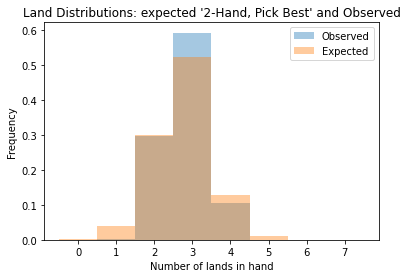

In [28]:
fig, ax2 = plt.subplots()
ax2.bar(np.arange(0,8), frequency, 1,  zorder = 1, alpha = .4, label = 'Observed')
ax2.bar(np.arange(0,8), final_hands, 1, zorder = 2, alpha= .4, label = 'Expected')
ax2.legend(loc = "upper right")
ax2.set_title("Land Distributions: expected '2-Hand, Pick Best' and Observed")
ax2.set_xlabel("Number of lands in hand")
ax2.set_ylabel("Frequency")

I'll simulate 5000 draws of 1046 hands and then plot where 95% of the lands fall. 

In [16]:
simulated_draws = []
n = 5000
for i in range(n):
    simulated_draws.append(np.random.choice(np.arange(0,8), num_hands, p = final_hands))

In [17]:
import collections

In [18]:
sim_counts = []
for i in range(len(simulated_draws)):
    sim_dict = collections.Counter(simulated_draws[i])
    count = [0,0,0,0,0,0,0,0]
    for key in range(0,8):
        count[key] = sim_dict[key]
    sim_counts.append(count)

In [19]:
df_sim_counts = pd.DataFrame(sim_counts)

In [20]:
quantile_025 = []
quantile_0975 = []
means = []
for i in range(0,8):
    quantile_025.append(df_sim_counts[i].quantile(0.025))
    quantile_0975.append(df_sim_counts[i].quantile(.975))
    means.append(df_sim_counts[i].mean())

Text(0, 0.5, 'Frequency')

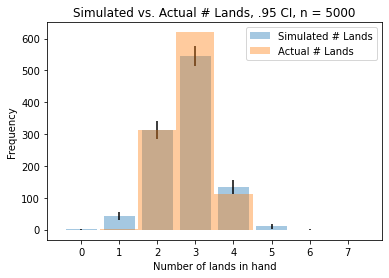

In [32]:
fig, ax2 = plt.subplots()
ci = [(0, 3), (30, 55), (285, 342), (515, 578), (111, 155), (4, 17), (0, 1), (0, 0)]
y_r = [means[i] - ci[i][1] for i in range(len(ci))]
plt.bar(range(len(means)), means, yerr=y_r, alpha=0.4, align='center', label = "Simulated # Lands")
ax2.bar(np.arange(0,8), land_counts, 1, zorder = 2, alpha= .4, label = "Actual # Lands")
ax2.set_title("Simulated vs. Actual # Lands, .95 CI, n = 5000")
ax2.legend(loc="upper right")
ax2.set_xlabel("Number of lands in hand")
ax2.set_ylabel("Frequency")

Above is the result after running 5000 simulations, where the simulated (where in each simulation, 1046 hands are drawn). 95% confidence intervals are shown in black. Based on the above, we're getting significantly fewer hands with 1 land and 5 lands, and significantly more hands with 3 lands (p < .05).  

## Future directions and questions

- Do these results carry over to different formats? In more traditional formats (like traditional draft, best of 3) where 1) the impact of random chance is already minimized because 3 matches are considered and 2) it's a format that is popularly played in real life, it seems very possible that there is less of an adjustment. 
- For multicolor decks, is MTGA also adjusting for more uniform color distribution?
- This should be tested over decks with a variety of land counts. Is it possible that MTGA is generous to decks with low land counts? This could inform deck construction for agro decks, in particular.  
- Is there a similar "smoothing" process for mana costs?